## Section 1: Dataset Loading and Preprocessing

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and preprocess dataset
max_features = 10000  # Only top 10,000 words
max_len = 100  # Maximum length of reviews

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to make all reviews the same length
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (25000, 100), x_test shape: (25000, 100)


## Section 2: Loading GloVe Embeddings


In [2]:
import numpy as np

# Path to GloVe embeddings (update path if different)
glove_path = "data/glove/glove.6B.100d.txt"
embedding_dim = 100

# Load GloVe embeddings
embeddings_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


In [3]:
import numpy as np

# Path to the GloVe file (update path if different)
glove_path = "data/glove/glove.6B.100d.txt"  # Using 100-dimensional embeddings
embedding_dim = 100  # Dimension of the GloVe vectors

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # The word
        coefs = np.asarray(values[1:], dtype="float32")  # The embedding vector
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Load the IMDb word index to map indices back to words
word_index = imdb.get_word_index()

# Prepare the embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))  # Matrix size: [max_features x embedding_dim]
for word, i in word_index.items():
    if i < max_features:  # Only consider words in the vocabulary
        embedding_vector = embeddings_index.get(word)  # Get the GloVe embedding for the word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Assign embedding to the matrix

print(f"Embedding matrix shape: {embedding_matrix.shape}")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Embedding matrix shape: (10000, 100)


## LSTM Model


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model
model = Sequential([
    Embedding(input_dim=max_features, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary after seeing input
x_dummy = np.zeros((1, max_len))  # Dummy input data (batch size 1, max_len)
model.build(input_shape=x_dummy.shape)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1, 100, 100)          │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (1, 128)               │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

## Training Code

In [7]:
# Training the model
batch_size = 32  # Number of samples per batch
epochs = 5  # Number of complete passes through the dataset

history = model.fit(
    x_train, y_train,  # Training data
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=1  # Display training progress
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5286 - loss: 0.6941 - val_accuracy: 0.5782 - val_loss: 0.6701
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.6283 - loss: 0.6441 - val_accuracy: 0.6292 - val_loss: 0.6288
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.6914 - loss: 0.5775 - val_accuracy: 0.6892 - val_loss: 0.5753
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7218 - loss: 0.5427 - val_accuracy: 0.6482 - val_loss: 0.6258
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7617 - loss: 0.4872 - val_accuracy: 0.7432 - val_loss: 0.4976


In [8]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7428 - loss: 0.5047
Test Loss: 0.5019, Test Accuracy: 0.7459


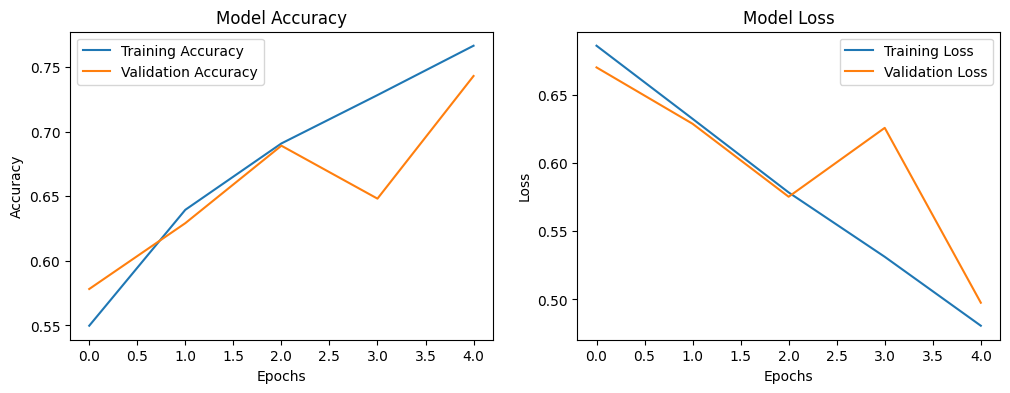

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
